# Knapsack Resolution

This code analyse the results of the resolution of the 0-1 knapsack problems with two complete methods and two incomplete methods done with ChocoSolver, as well as a Linear Programming method done with OR-tools.

Instances are of three kind: 
- **Easy**, with a size of $n=50$ objects;
- **Medium**, with a size of $n=100$ objects;
- **Difficult**, with a size of $n=1000$ objects.

All objects weights are drawn in a data range of $R=1000$, and instances are taken from the benchmark available on [this repository](https://github.com/likr/kplib).

-----

In [1]:
#### Library Imports ####
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

----

In [2]:
#### Reading Data ####
filename = 'results2.csv'
data_path = os.path.join('..', '..', 'results', filename)
if not os.path.exists(data_path):
    print(f"Error: The file {filename} does not exist in the results directory.")
else :
    data = pd.read_csv(data_path, header=0, sep=',', index_col=False)
    print(f"Data from {filename} successfully loaded.")

Data from results2.csv successfully loaded.


In [3]:
data.head()

,Instance,Difficulty,Class,n,Capacity,TotalWeight,TotalProfit,Method,Value,Time(ms),Nodes,Optimal,OptimalKnown,Gap(%)
0,02StronglyCorrelated_n00050_R01000_s000,facile,Unknown,50,14239,28763,33763,Complete_RatioFirst,17539,182,2499,True,-1,-1
1,02StronglyCorrelated_n00050_R01000_s000,facile,Unknown,50,14239,28763,33763,Complete_DomOverWDeg,17539,6338,483572,True,-1,-1
2,02StronglyCorrelated_n00050_R01000_s000,facile,Unknown,50,14239,28763,33763,Complete_MILP_ORTools,17539,43,-1,True,-1,-1
3,02StronglyCorrelated_n00050_R01000_s000,facile,Unknown,50,14239,28763,33763,Probabilistic_Greedy,16882,2,0,False,-1,-1
4,02StronglyCorrelated_n00050_R01000_s000,facile,Unknown,50,14239,28763,33763,Incomplete_LNS,16735,1,26,False,-1,-1


In [4]:
#### Adding TimeOut Column ####
timeout = 60_000 * 5  # 5 minutes in milliseconds
data["TimeOut"] = data["Time(ms)"].astype(int) >= timeout 
data.loc[(data["Optimal"] == False) & (data["Method"].isin(["Complete_RatioFirst", "Complete_DomOverWDeg"])), "TimeOut"] = True # if Complete method or not optimal it means they have timed out
data.tail(10)

,Instance,Difficulty,Class,n,Capacity,TotalWeight,TotalProfit,Method,Value,Time(ms),Nodes,Optimal,OptimalKnown,Gap(%),TimeOut
140,02StronglyCorrelated_n01000_R01000_s008,difficile,Unknown,1000,250298,505602,605602,Complete_RatioFirst,320098,300000,1796792,False,-1,-1,True
141,02StronglyCorrelated_n01000_R01000_s008,difficile,Unknown,1000,250298,505602,605602,Complete_DomOverWDeg,300198,300000,1544933,False,-1,-1,True
142,02StronglyCorrelated_n01000_R01000_s008,difficile,Unknown,1000,250298,505602,605602,Complete_MILP_ORTools,320097,345,-1,True,-1,-1,False
143,02StronglyCorrelated_n01000_R01000_s008,difficile,Unknown,1000,250298,505602,605602,Probabilistic_Greedy,304598,32,0,False,-1,-1,False
144,02StronglyCorrelated_n01000_R01000_s008,difficile,Unknown,1000,250298,505602,605602,Incomplete_LNS,299395,19,492,False,-1,-1,False
145,02StronglyCorrelated_n01000_R01000_s009,difficile,Unknown,1000,239451,483692,583692,Complete_RatioFirst,310651,300001,2358710,False,-1,-1,True
146,02StronglyCorrelated_n01000_R01000_s009,difficile,Unknown,1000,239451,483692,583692,Complete_DomOverWDeg,289851,299999,4270429,False,-1,-1,True
147,02StronglyCorrelated_n01000_R01000_s009,difficile,Unknown,1000,239451,483692,583692,Complete_MILP_ORTools,310650,445,-1,True,-1,-1,False
148,02StronglyCorrelated_n01000_R01000_s009,difficile,Unknown,1000,239451,483692,583692,Probabilistic_Greedy,292534,15,0,False,-1,-1,False
149,02StronglyCorrelated_n01000_R01000_s009,difficile,Unknown,1000,239451,483692,583692,Incomplete_LNS,289350,11,500,False,-1,-1,False


In [5]:
#### Testing if incomplete methods give near optimal solutions ####
threshold = 0.01  # 1% optimality gap
incomplete_methods = ['Incomplete_LNS', 'Probabilistic_Greedy']
ground_truth_method = 'Complete_MILP_ORTools'
data["Gap(%)"] = data["Gap(%)"].astype(str)  # Ensure the column is of string type to hold formatted values
for method in incomplete_methods:
    merged = pd.merge(
        data[data['Method'] == method],
        data[data['Method'] == ground_truth_method],
        on=['n', 'Capacity', 'Instance'],
        suffixes=('_incomplete', '_ground_truth')
    )
    merged['optimality_gap'] = (merged['Value_ground_truth'] - merged['Value_incomplete']) / merged['Value_ground_truth']
    avg_gap = merged['optimality_gap'].mean()
    print(f"Average optimality gap for {method}: {avg_gap:.4f}")
    
    # Mark as optimal the found solution is within the threshold of the ground truth for this particular (method, n, Capacity, Instance)
    merged['is_optimal'] = merged['optimality_gap'] <= threshold
    for idx, row in merged.iterrows():
        data.loc[
            (data['Method'] == method) &
            (data['n'] == row['n']) &
            (data['Capacity'] == row['Capacity']) &
            (data['Instance'] == row['Instance']),
            ['Optimal', 'Gap(%)']
        ] = row['is_optimal'], f"{row['optimality_gap'] * 100:.2f}"

data.head(10)

Average optimality gap for Incomplete_LNS: 0.0561
Average optimality gap for Probabilistic_Greedy: 0.0472


,Instance,Difficulty,Class,n,Capacity,TotalWeight,TotalProfit,Method,Value,Time(ms),Nodes,Optimal,OptimalKnown,Gap(%),TimeOut
0,02StronglyCorrelated_n00050_R01000_s000,facile,Unknown,50,14239,28763,33763,Complete_RatioFirst,17539,182,2499,True,-1,-1,False
1,02StronglyCorrelated_n00050_R01000_s000,facile,Unknown,50,14239,28763,33763,Complete_DomOverWDeg,17539,6338,483572,True,-1,-1,False
2,02StronglyCorrelated_n00050_R01000_s000,facile,Unknown,50,14239,28763,33763,Complete_MILP_ORTools,17539,43,-1,True,-1,-1,False
3,02StronglyCorrelated_n00050_R01000_s000,facile,Unknown,50,14239,28763,33763,Probabilistic_Greedy,16882,2,0,False,-1,3.75,False
4,02StronglyCorrelated_n00050_R01000_s000,facile,Unknown,50,14239,28763,33763,Incomplete_LNS,16735,1,26,False,-1,4.58,False
5,02StronglyCorrelated_n00050_R01000_s001,facile,Unknown,50,11793,23823,28823,Complete_RatioFirst,15293,137,22074,True,-1,-1,False
6,02StronglyCorrelated_n00050_R01000_s001,facile,Unknown,50,11793,23823,28823,Complete_DomOverWDeg,15293,1090,101766,True,-1,-1,False
7,02StronglyCorrelated_n00050_R01000_s001,facile,Unknown,50,11793,23823,28823,Complete_MILP_ORTools,15292,16,-1,True,-1,-1,False
8,02StronglyCorrelated_n00050_R01000_s001,facile,Unknown,50,11793,23823,28823,Probabilistic_Greedy,14728,1,0,False,-1,3.69,False
9,02StronglyCorrelated_n00050_R01000_s001,facile,Unknown,50,11793,23823,28823,Incomplete_LNS,14366,0,27,False,-1,6.06,False


In [6]:
#### Testing if complete methods give near optimal solutions ####
threshold = 0.01  # 1% optimality gap
complete_methods = ['Complete_RatioFirst', 'Complete_DomOverWDeg'] # we consider MILP as the ground truth so we test other complete methods
ground_truth_method = 'Complete_MILP_ORTools'
data["Gap(%)"] = data["Gap(%)"].astype(str)  # Ensure the column is of string type to hold formatted values
for method in complete_methods:
    merged = pd.merge(
        data[data['Method'] == method],
        data[data['Method'] == ground_truth_method],
        on=['n', 'Capacity', 'Instance'],
        suffixes=('_incomplete', '_ground_truth')
    )
    merged['optimality_gap'] = (merged['Value_ground_truth'] - merged['Value_incomplete']) / merged['Value_ground_truth']
    avg_gap = merged['optimality_gap'].mean()
    print(f"Average optimality gap for {method}: {avg_gap:.4f}")
    
    # Mark as optimal the found solution is within the threshold of the ground truth for this particular (method, n, Capacity, Instance)
    merged['is_optimal'] = merged['optimality_gap'] <= threshold
    for idx, row in merged.iterrows():
        data.loc[
            (data['Method'] == method) &
            (data['n'] == row['n']) &
            (data['Capacity'] == row['Capacity']) &
            (data['Instance'] == row['Instance']),
            ['Optimal', 'Gap(%)']
        ] = row['is_optimal'], f"{row['optimality_gap'] * 100:.2f}"

data.loc[(data['Method'] == 'Complete_MILP_ORTools'), 'Gap(%)'] = "0.00" # MILP has always a 0% gap as it is the ground truth
data.head(10)

Average optimality gap for Complete_RatioFirst: -0.0000
Average optimality gap for Complete_DomOverWDeg: 0.0305


,Instance,Difficulty,Class,n,Capacity,TotalWeight,TotalProfit,Method,Value,Time(ms),Nodes,Optimal,OptimalKnown,Gap(%),TimeOut
0,02StronglyCorrelated_n00050_R01000_s000,facile,Unknown,50,14239,28763,33763,Complete_RatioFirst,17539,182,2499,True,-1,0.00,False
1,02StronglyCorrelated_n00050_R01000_s000,facile,Unknown,50,14239,28763,33763,Complete_DomOverWDeg,17539,6338,483572,True,-1,0.00,False
2,02StronglyCorrelated_n00050_R01000_s000,facile,Unknown,50,14239,28763,33763,Complete_MILP_ORTools,17539,43,-1,True,-1,0.00,False
3,02StronglyCorrelated_n00050_R01000_s000,facile,Unknown,50,14239,28763,33763,Probabilistic_Greedy,16882,2,0,False,-1,3.75,False
4,02StronglyCorrelated_n00050_R01000_s000,facile,Unknown,50,14239,28763,33763,Incomplete_LNS,16735,1,26,False,-1,4.58,False
5,02StronglyCorrelated_n00050_R01000_s001,facile,Unknown,50,11793,23823,28823,Complete_RatioFirst,15293,137,22074,True,-1,-0.01,False
6,02StronglyCorrelated_n00050_R01000_s001,facile,Unknown,50,11793,23823,28823,Complete_DomOverWDeg,15293,1090,101766,True,-1,-0.01,False
7,02StronglyCorrelated_n00050_R01000_s001,facile,Unknown,50,11793,23823,28823,Complete_MILP_ORTools,15292,16,-1,True,-1,0.00,False
8,02StronglyCorrelated_n00050_R01000_s001,facile,Unknown,50,11793,23823,28823,Probabilistic_Greedy,14728,1,0,False,-1,3.69,False
9,02StronglyCorrelated_n00050_R01000_s001,facile,Unknown,50,11793,23823,28823,Incomplete_LNS,14366,0,27,False,-1,6.06,False


In [7]:
data.tail(10)

,Instance,Difficulty,Class,n,Capacity,TotalWeight,TotalProfit,Method,Value,Time(ms),Nodes,Optimal,OptimalKnown,Gap(%),TimeOut
140,02StronglyCorrelated_n01000_R01000_s008,difficile,Unknown,1000,250298,505602,605602,Complete_RatioFirst,320098,300000,1796792,True,-1,-0.00,True
141,02StronglyCorrelated_n01000_R01000_s008,difficile,Unknown,1000,250298,505602,605602,Complete_DomOverWDeg,300198,300000,1544933,False,-1,6.22,True
142,02StronglyCorrelated_n01000_R01000_s008,difficile,Unknown,1000,250298,505602,605602,Complete_MILP_ORTools,320097,345,-1,True,-1,0.00,False
143,02StronglyCorrelated_n01000_R01000_s008,difficile,Unknown,1000,250298,505602,605602,Probabilistic_Greedy,304598,32,0,False,-1,4.84,False
144,02StronglyCorrelated_n01000_R01000_s008,difficile,Unknown,1000,250298,505602,605602,Incomplete_LNS,299395,19,492,False,-1,6.47,False
145,02StronglyCorrelated_n01000_R01000_s009,difficile,Unknown,1000,239451,483692,583692,Complete_RatioFirst,310651,300001,2358710,True,-1,-0.00,True
146,02StronglyCorrelated_n01000_R01000_s009,difficile,Unknown,1000,239451,483692,583692,Complete_DomOverWDeg,289851,299999,4270429,False,-1,6.70,True
147,02StronglyCorrelated_n01000_R01000_s009,difficile,Unknown,1000,239451,483692,583692,Complete_MILP_ORTools,310650,445,-1,True,-1,0.00,False
148,02StronglyCorrelated_n01000_R01000_s009,difficile,Unknown,1000,239451,483692,583692,Probabilistic_Greedy,292534,15,0,False,-1,5.83,False
149,02StronglyCorrelated_n01000_R01000_s009,difficile,Unknown,1000,239451,483692,583692,Incomplete_LNS,289350,11,500,False,-1,6.86,False


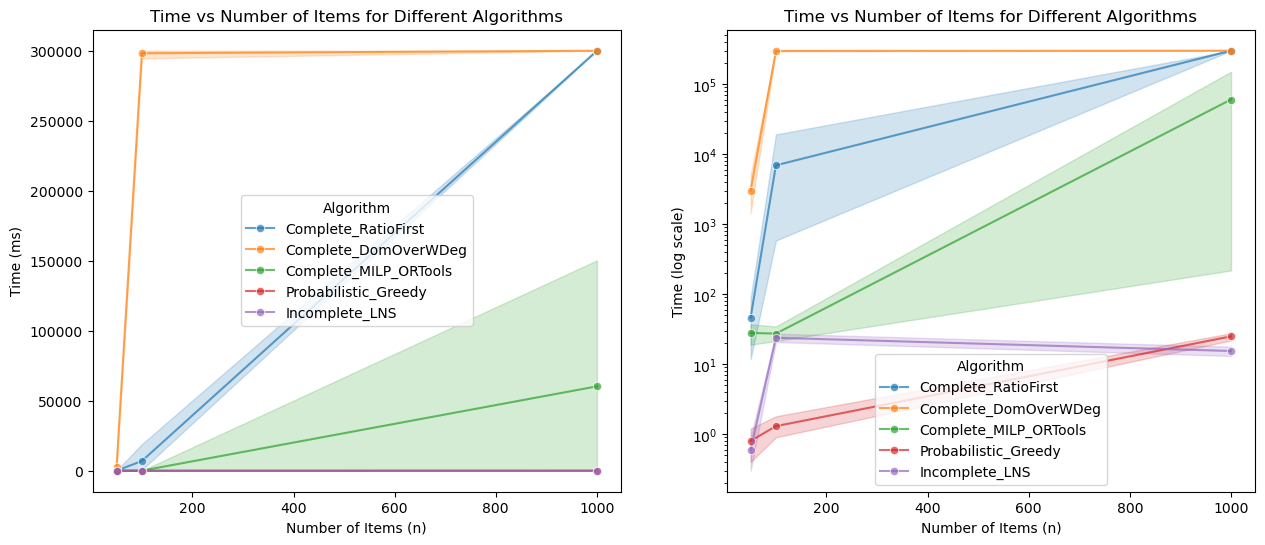

In [8]:
#### Plot time vs n for different algorithms ####
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
sns.lineplot(data=data, x='n', y='Time(ms)', hue='Method', marker='o', alpha=0.7)
plt.xlabel('Number of Items (n)')
plt.ylabel('Time (ms)')
plt.title('Time vs Number of Items for Different Algorithms')
plt.legend(title='Algorithm')

plt.subplot(1, 2, 2)
sns.lineplot(data=data, x='n', y='Time(ms)', hue='Method', marker='o', alpha=0.7)
plt.yscale('log')
plt.xlabel('Number of Items (n)')
plt.ylabel('Time (log scale)')
plt.title('Time vs Number of Items for Different Algorithms')
plt.legend(title='Algorithm')
plt.show()

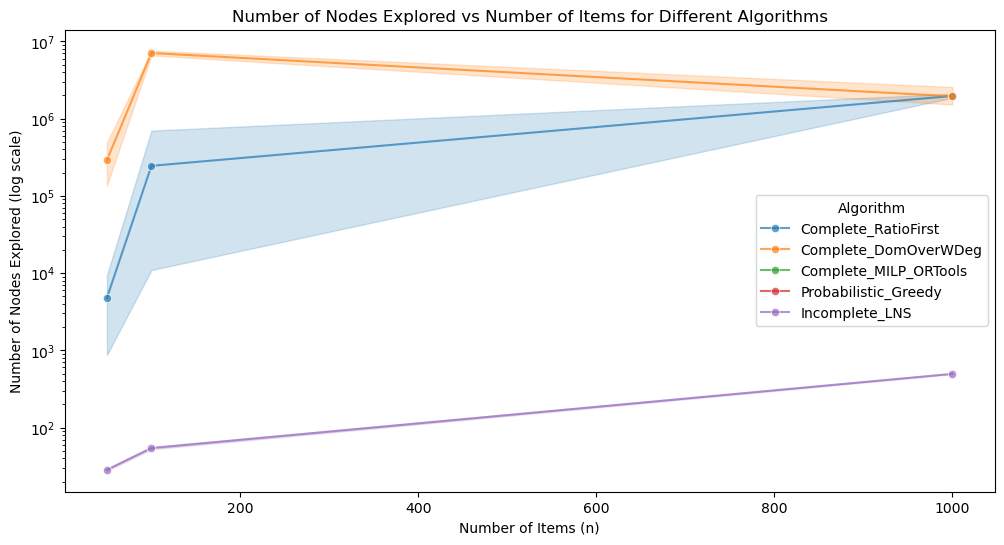

In [9]:
#### Plot the number of nodes vs n for different algorithms ####
plt.figure(figsize=(12, 6))
sns.lineplot(data=data, x='n', y='Nodes', hue='Method', marker='o', alpha=0.7)
plt.yscale('log')
plt.xlabel('Number of Items (n)')
plt.ylabel('Number of Nodes Explored (log scale)')
plt.title('Number of Nodes Explored vs Number of Items for Different Algorithms')
plt.legend(title='Algorithm')
plt.show()

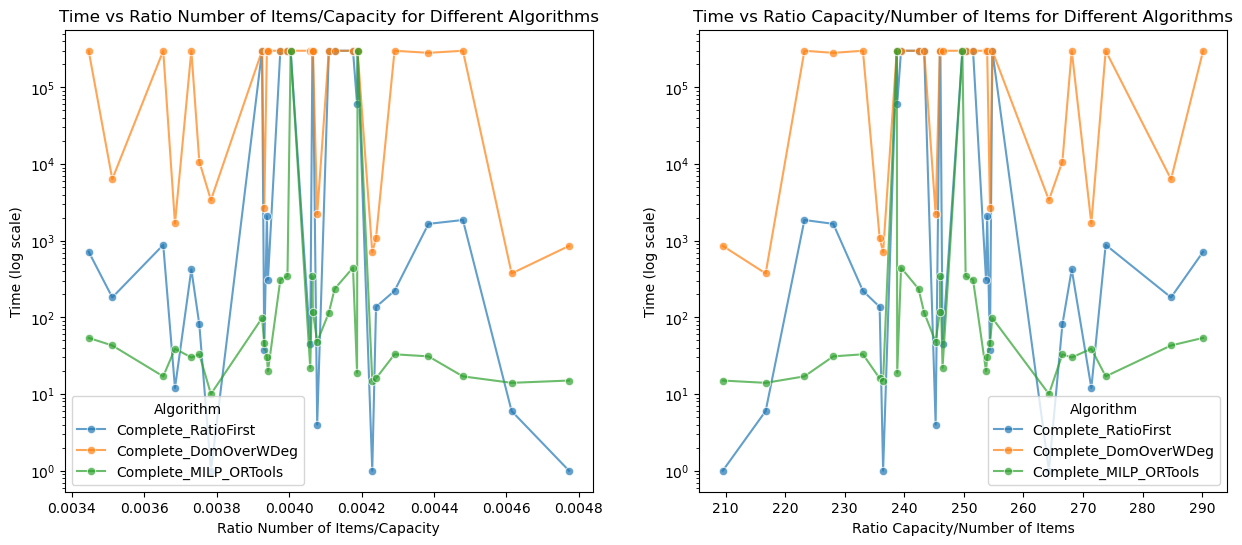

In [10]:
#### Plot time vs ratio n/capacity for different algorithms ####
complete_methods = ['Complete_RatioFirst', 'Complete_DomOverWDeg', 'Complete_MILP_ORTools']
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
sns.lineplot(data=data.loc[data['Method'].isin(complete_methods)], x=data['n'] / data['Capacity'], y='Time(ms)', hue='Method', marker='o', alpha=0.7)
plt.yscale('log')
plt.xlabel('Ratio Number of Items/Capacity')
plt.ylabel('Time (log scale)')
plt.title('Time vs Ratio Number of Items/Capacity for Different Algorithms')
plt.legend(title='Algorithm')

plt.subplot(1, 2, 2)
sns.lineplot(data=data.loc[data['Method'].isin(complete_methods)], x=data['Capacity'] / data['n'], y='Time(ms)', hue='Method', marker='o', alpha=0.7)
plt.yscale('log')
plt.xlabel('Ratio Capacity/Number of Items')
plt.ylabel('Time (log scale)')
plt.title('Time vs Ratio Capacity/Number of Items for Different Algorithms')
plt.legend(title='Algorithm')

plt.show()

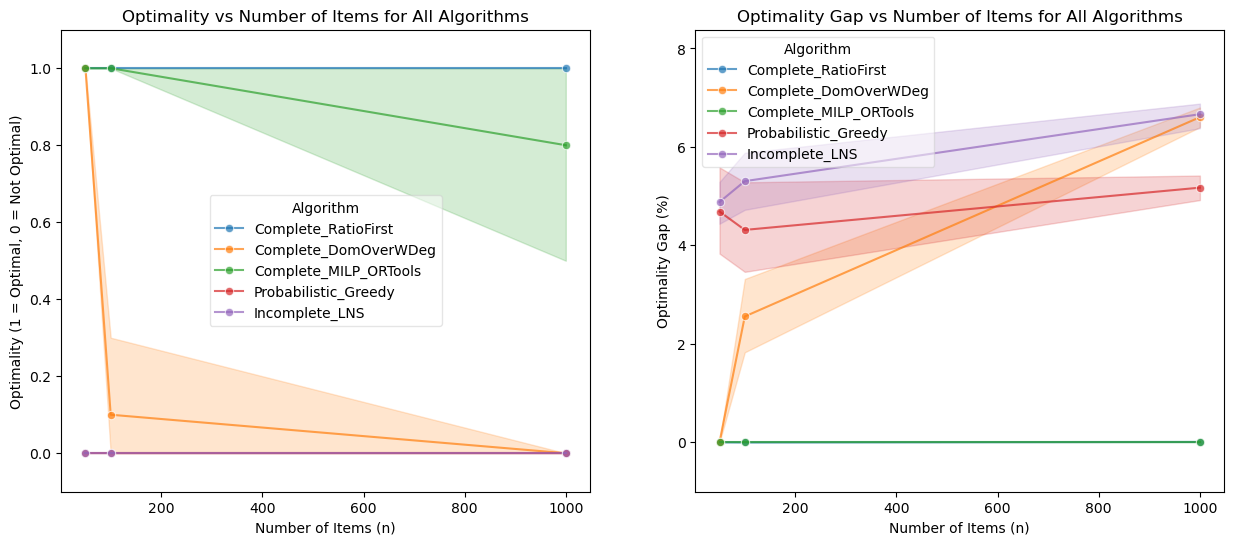

In [11]:
#### Plot optimality vs n for all algorithms ####
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
sns.lineplot(data=data, x='n', y='Optimal', hue='Method', marker='o', alpha=0.7)
plt.ylim(-0.1, 1.1)
plt.xlabel('Number of Items (n)')
plt.ylabel('Optimality (1 = Optimal, 0 = Not Optimal)')
plt.title('Optimality vs Number of Items for All Algorithms')
plt.legend(title='Algorithm', fancybox=True, framealpha=0.5)

plt.subplot(1, 2, 2)
data["Gap(%)"] = data["Gap(%)"].astype(float)  # Convert Gap(%) to float for plotting
sns.lineplot(data=data, x='n', y='Gap(%)', hue='Method', marker='o', alpha=0.7)
plt.ylim(data['Gap(%)'].min() - 1, data['Gap(%)'].max() + 1)
plt.xlabel('Number of Items (n)')
plt.ylabel('Optimality Gap (%)')
plt.title('Optimality Gap vs Number of Items for All Algorithms')
plt.legend(title='Algorithm', fancybox=True, framealpha=0.5)
plt.show()

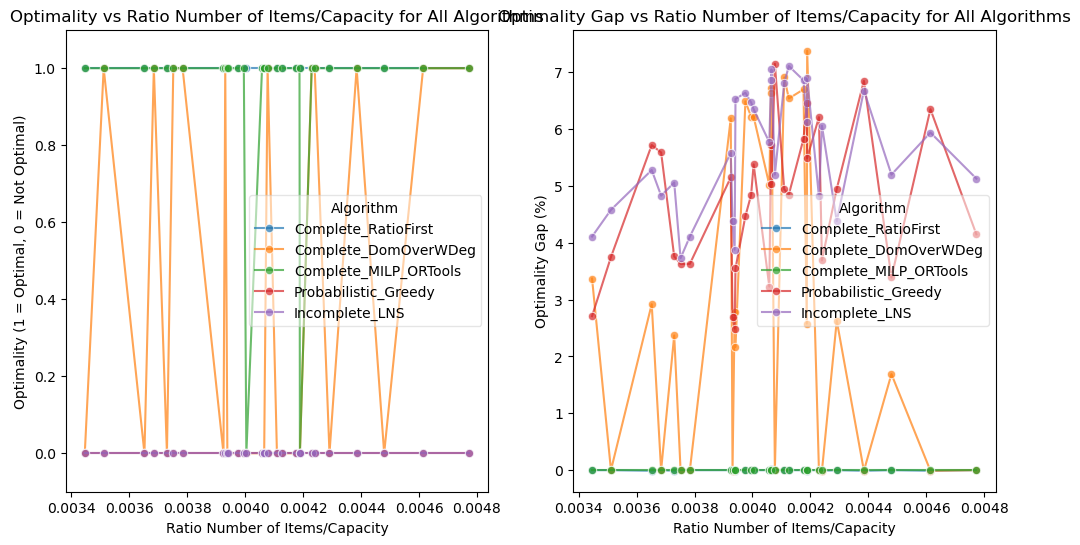

In [12]:
#### Plot optimality vs Ratio n/Capacity for all algorithms ####
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.lineplot(data=data, x=data['n'] / data['Capacity'], y='Optimal', hue='Method', marker='o', alpha=0.7)
plt.ylim(-0.1, 1.1)
plt.xlabel('Ratio Number of Items/Capacity')
plt.ylabel('Optimality (1 = Optimal, 0 = Not Optimal)')
plt.title('Optimality vs Ratio Number of Items/Capacity for All Algorithms')
plt.legend(title='Algorithm', fancybox=True, framealpha=0.5)
plt.subplot(1, 2, 2)
data["Gap(%)"] = data["Gap(%)"].astype(float)  # Convert Gap(%) to float for plotting
sns.lineplot(data=data, x=data['n'] / data['Capacity'], y='Gap(%)', hue='Method', marker='o', alpha=0.7)
plt.xlabel('Ratio Number of Items/Capacity')
plt.ylabel('Optimality Gap (%)')
plt.title('Optimality Gap vs Ratio Number of Items/Capacity for All Algorithms')
plt.legend(title='Algorithm', fancybox=True, framealpha=0.5)
plt.show()

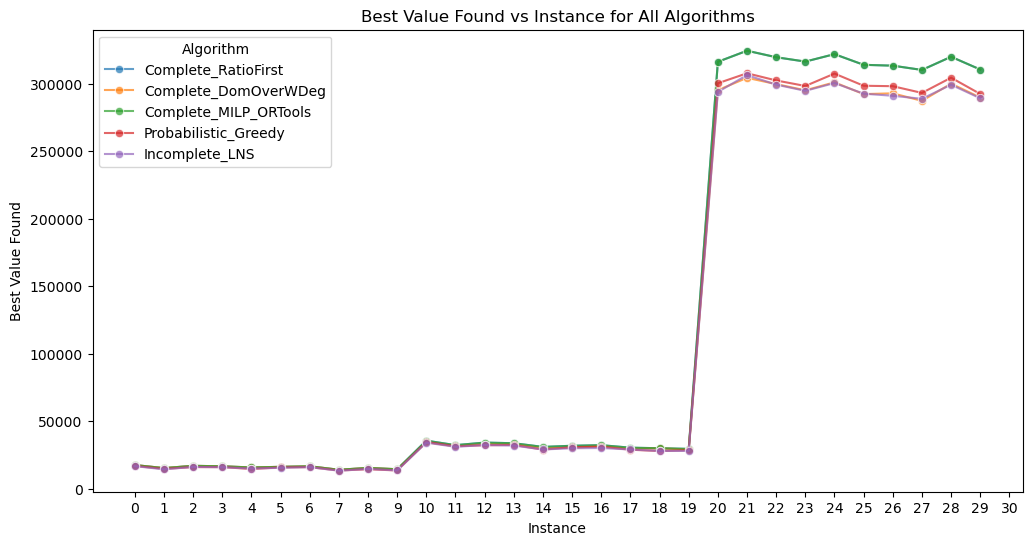

In [13]:
#### Plot best value found per instances for all algorithms ####
plt.figure(figsize=(12, 6))
sns.lineplot(data=data, x='Instance', y='Value', hue='Method', marker='o', alpha=0.7)
plt.xticks(ticks=range(0, len(data['Instance'].unique())+1), labels=range(0, len(data['Instance'].unique())+1))
plt.xlabel('Instance')
plt.ylabel('Best Value Found')
plt.title('Best Value Found vs Instance for All Algorithms')
plt.legend(title='Algorithm')
plt.show()

-----

In [14]:
#### Reading Data ####
filename_bis = 'results2bis.csv'
data_path_bis = os.path.join('..', '..', 'results', filename_bis)
if not os.path.exists(data_path_bis):
    print(f"Error: The file {filename_bis} does not exist in the results directory.")
else :
    data_bis = pd.read_csv(data_path_bis, header=0, sep=',', index_col=False)
    print(f"Data from {filename_bis} successfully loaded.")

Data from results2bis.csv successfully loaded.


In [16]:
#### Adding TimeOut Column ####
timeout = 60_000 * 5  # 5 minutes in milliseconds
data_bis["TimeOut"] = data_bis["Time(ms)"].astype(int) >= timeout 
data_bis.loc[(data_bis["Optimal"] == False) & (data_bis["Method"].isin(["Complete_RatioFirst", "Complete_DomOverWDeg"])), "TimeOut"] = True # if Complete method or not optimal it means they have timed out
data_bis.tail(10)

,Instance,Difficulty,Class,n,Capacity,TotalWeight,TotalProfit,Method,Value,Time(ms),Nodes,Optimal,OptimalKnown,Gap(%),TimeOut
90,02StronglyCorrelated_n00500_R01000_s008,difficile,Unknown,500,128354,259277,309277,Complete_RatioFirst,163054,300001,3858106,False,-1,-1,True
91,02StronglyCorrelated_n00500_R01000_s008,difficile,Unknown,500,128354,259277,309277,Complete_DomOverWDeg,153954,299998,3402179,False,-1,-1,True
92,02StronglyCorrelated_n00500_R01000_s008,difficile,Unknown,500,128354,259277,309277,Complete_MILP_ORTools,163054,246,-1,True,-1,-1,False
93,02StronglyCorrelated_n00500_R01000_s008,difficile,Unknown,500,128354,259277,309277,Probabilistic_Greedy,154750,7,0,False,-1,-1,False
94,02StronglyCorrelated_n00500_R01000_s008,difficile,Unknown,500,128354,259277,309277,Incomplete_LNS,153850,16,256,False,-1,-1,False
95,02StronglyCorrelated_n00500_R01000_s009,difficile,Unknown,500,119918,242235,292235,Complete_RatioFirst,155718,300026,3250250,False,-1,-1,True
96,02StronglyCorrelated_n00500_R01000_s009,difficile,Unknown,500,119918,242235,292235,Complete_DomOverWDeg,145318,300020,3497754,False,-1,-1,True
97,02StronglyCorrelated_n00500_R01000_s009,difficile,Unknown,500,119918,242235,292235,Complete_MILP_ORTools,155718,321,-1,True,-1,-1,False
98,02StronglyCorrelated_n00500_R01000_s009,difficile,Unknown,500,119918,242235,292235,Probabilistic_Greedy,146496,15,0,False,-1,-1,False
99,02StronglyCorrelated_n00500_R01000_s009,difficile,Unknown,500,119918,242235,292235,Incomplete_LNS,145618,72,258,False,-1,-1,False


In [17]:
#### Testing if incomplete methods give near optimal solutions ####
threshold = 0.01  # 1% optimality gap
incomplete_methods = ['Incomplete_LNS', 'Probabilistic_Greedy']
ground_truth_method = 'Complete_MILP_ORTools'
data_bis["Gap(%)"] = data_bis["Gap(%)"].astype(str)  # Ensure the column is of string type to hold formatted values
for method in incomplete_methods:
    merged = pd.merge(
        data_bis[data_bis['Method'] == method],
        data_bis[data_bis['Method'] == ground_truth_method],
        on=['n', 'Capacity', 'Instance'],
        suffixes=('_incomplete', '_ground_truth')
    )
    merged['optimality_gap'] = (merged['Value_ground_truth'] - merged['Value_incomplete']) / merged['Value_ground_truth']
    avg_gap = merged['optimality_gap'].mean()
    print(f"Average optimality gap for {method}: {avg_gap:.4f}")
    
    # Mark as optimal the found solution is within the threshold of the ground truth for this particular (method, n, Capacity, Instance)
    merged['is_optimal'] = merged['optimality_gap'] <= threshold
    for idx, row in merged.iterrows():
        data_bis.loc[
            (data_bis['Method'] == method) &
            (data_bis['n'] == row['n']) &
            (data_bis['Capacity'] == row['Capacity']) &
            (data_bis['Instance'] == row['Instance']),
            ['Optimal', 'Gap(%)']
        ] = row['is_optimal'], f"{row['optimality_gap'] * 100:.2f}"

data_bis.head(10)

Average optimality gap for Incomplete_LNS: 0.0615
Average optimality gap for Probabilistic_Greedy: 0.0474


,Instance,Difficulty,Class,n,Capacity,TotalWeight,TotalProfit,Method,Value,Time(ms),Nodes,Optimal,OptimalKnown,Gap(%),TimeOut
0,02StronglyCorrelated_n00200_R01000_s000,moyen,Unknown,200,51563,104158,124158,Complete_RatioFirst,65363,300000,6979923,False,-1,-1,True
1,02StronglyCorrelated_n00200_R01000_s000,moyen,Unknown,200,51563,104158,124158,Complete_DomOverWDeg,62363,300001,8223964,False,-1,-1,True
2,02StronglyCorrelated_n00200_R01000_s000,moyen,Unknown,200,51563,104158,124158,Complete_MILP_ORTools,65361,25,-1,True,-1,-1,False
3,02StronglyCorrelated_n00200_R01000_s000,moyen,Unknown,200,51563,104158,124158,Probabilistic_Greedy,62452,6,0,False,-1,4.45,False
4,02StronglyCorrelated_n00200_R01000_s000,moyen,Unknown,200,51563,104158,124158,Incomplete_LNS,60763,1,93,False,-1,7.03,False
5,02StronglyCorrelated_n00200_R01000_s001,moyen,Unknown,200,48106,97175,117175,Complete_RatioFirst,62206,11888,429938,True,-1,-1,False
6,02StronglyCorrelated_n00200_R01000_s001,moyen,Unknown,200,48106,97175,117175,Complete_DomOverWDeg,58906,300001,12166241,False,-1,-1,True
7,02StronglyCorrelated_n00200_R01000_s001,moyen,Unknown,200,48106,97175,117175,Complete_MILP_ORTools,62206,21,-1,True,-1,-1,False
8,02StronglyCorrelated_n00200_R01000_s001,moyen,Unknown,200,48106,97175,117175,Probabilistic_Greedy,59335,1,0,False,-1,4.62,False
9,02StronglyCorrelated_n00200_R01000_s001,moyen,Unknown,200,48106,97175,117175,Incomplete_LNS,57703,2,97,False,-1,7.24,False


In [18]:
#### Testing if complete methods give near optimal solutions ####
threshold = 0.01  # 1% optimality gap
complete_methods = ['Complete_RatioFirst', 'Complete_DomOverWDeg'] # we consider MILP as the ground truth so we test other complete methods
ground_truth_method = 'Complete_MILP_ORTools'
data_bis["Gap(%)"] = data_bis["Gap(%)"].astype(str)  # Ensure the column is of string type to hold formatted values
for method in complete_methods:
    merged = pd.merge(
        data_bis[data_bis['Method'] == method],
        data_bis[data_bis['Method'] == ground_truth_method],
        on=['n', 'Capacity', 'Instance'],
        suffixes=('_incomplete', '_ground_truth')
    )
    merged['optimality_gap'] = (merged['Value_ground_truth'] - merged['Value_incomplete']) / merged['Value_ground_truth']
    avg_gap = merged['optimality_gap'].mean()
    print(f"Average optimality gap for {method}: {avg_gap:.4f}")
    
    # Mark as optimal the found solution is within the threshold of the ground truth for this particular (method, n, Capacity, Instance)
    merged['is_optimal'] = merged['optimality_gap'] <= threshold
    for idx, row in merged.iterrows():
        data_bis.loc[
            (data_bis['Method'] == method) &
            (data_bis['n'] == row['n']) &
            (data_bis['Capacity'] == row['Capacity']) &
            (data_bis['Instance'] == row['Instance']),
            ['Optimal', 'Gap(%)']
        ] = row['is_optimal'], f"{row['optimality_gap'] * 100:.2f}"

data_bis.loc[(data_bis['Method'] == 'Complete_MILP_ORTools'), 'Gap(%)'] = "0.00" # MILP has always a 0% gap as it is the ground truth
data_bis.head(10)

Average optimality gap for Complete_RatioFirst: -0.0000
Average optimality gap for Complete_DomOverWDeg: 0.0585


,Instance,Difficulty,Class,n,Capacity,TotalWeight,TotalProfit,Method,Value,Time(ms),Nodes,Optimal,OptimalKnown,Gap(%),TimeOut
0,02StronglyCorrelated_n00200_R01000_s000,moyen,Unknown,200,51563,104158,124158,Complete_RatioFirst,65363,300000,6979923,True,-1,-0.00,True
1,02StronglyCorrelated_n00200_R01000_s000,moyen,Unknown,200,51563,104158,124158,Complete_DomOverWDeg,62363,300001,8223964,False,-1,4.59,True
2,02StronglyCorrelated_n00200_R01000_s000,moyen,Unknown,200,51563,104158,124158,Complete_MILP_ORTools,65361,25,-1,True,-1,0.00,False
3,02StronglyCorrelated_n00200_R01000_s000,moyen,Unknown,200,51563,104158,124158,Probabilistic_Greedy,62452,6,0,False,-1,4.45,False
4,02StronglyCorrelated_n00200_R01000_s000,moyen,Unknown,200,51563,104158,124158,Incomplete_LNS,60763,1,93,False,-1,7.03,False
5,02StronglyCorrelated_n00200_R01000_s001,moyen,Unknown,200,48106,97175,117175,Complete_RatioFirst,62206,11888,429938,True,-1,0.00,False
6,02StronglyCorrelated_n00200_R01000_s001,moyen,Unknown,200,48106,97175,117175,Complete_DomOverWDeg,58906,300001,12166241,False,-1,5.30,True
7,02StronglyCorrelated_n00200_R01000_s001,moyen,Unknown,200,48106,97175,117175,Complete_MILP_ORTools,62206,21,-1,True,-1,0.00,False
8,02StronglyCorrelated_n00200_R01000_s001,moyen,Unknown,200,48106,97175,117175,Probabilistic_Greedy,59335,1,0,False,-1,4.62,False
9,02StronglyCorrelated_n00200_R01000_s001,moyen,Unknown,200,48106,97175,117175,Incomplete_LNS,57703,2,97,False,-1,7.24,False


In [20]:
#### Concatenate Data ####
data_concat = pd.concat([data, data_bis], ignore_index=True)
print(len(data), len(data_bis), len(data_concat))

150 100 250


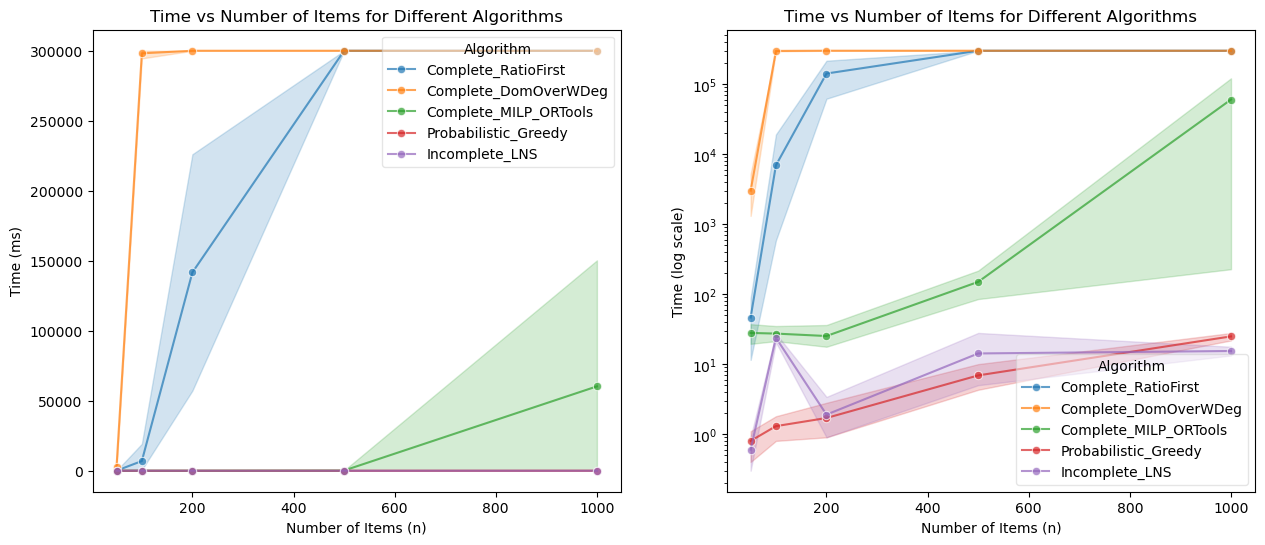

In [34]:
#### Plot time vs n for different algorithms ####
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
sns.lineplot(data=data_concat, x='n', y='Time(ms)', hue='Method', marker='o', alpha=0.7)
plt.xlabel('Number of Items (n)')
plt.ylabel('Time (ms)')
plt.title('Time vs Number of Items for Different Algorithms')
plt.legend(title='Algorithm', fancybox=True, framealpha=0.5, loc='upper right')

plt.subplot(1, 2, 2)
sns.lineplot(data=data_concat, x='n', y='Time(ms)', hue='Method', marker='o', alpha=0.7)
plt.yscale('log')
plt.xlabel('Number of Items (n)')
plt.ylabel('Time (log scale)')
plt.title('Time vs Number of Items for Different Algorithms')
plt.legend(title='Algorithm', fancybox=True, framealpha=0.5, loc='lower right')
plt.show()

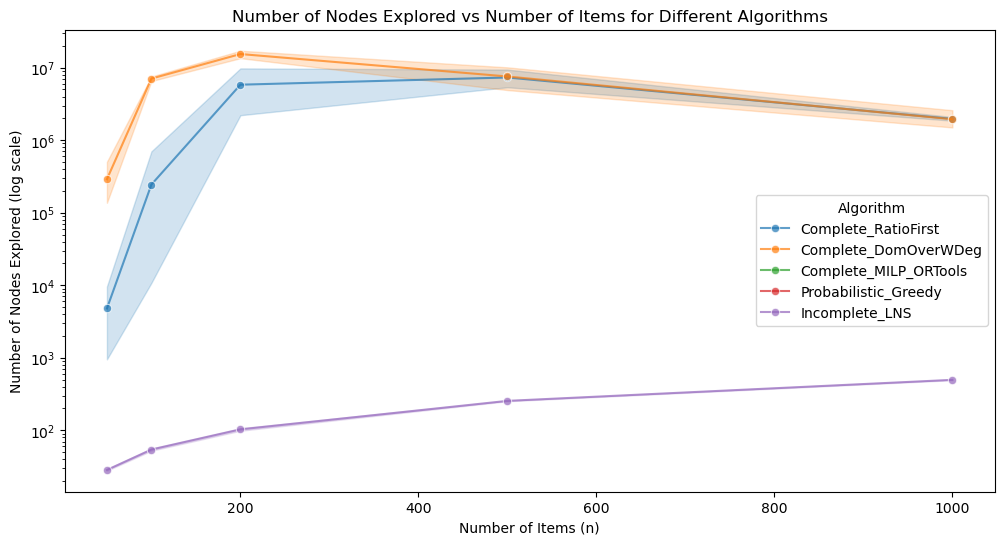

In [23]:
#### Plot the number of nodes vs n for different algorithms ####
plt.figure(figsize=(12, 6))
sns.lineplot(data=data_concat, x='n', y='Nodes', hue='Method', marker='o', alpha=0.7)
plt.yscale('log')
plt.xlabel('Number of Items (n)')
plt.ylabel('Number of Nodes Explored (log scale)')
plt.title('Number of Nodes Explored vs Number of Items for Different Algorithms')
plt.legend(title='Algorithm')
plt.show()

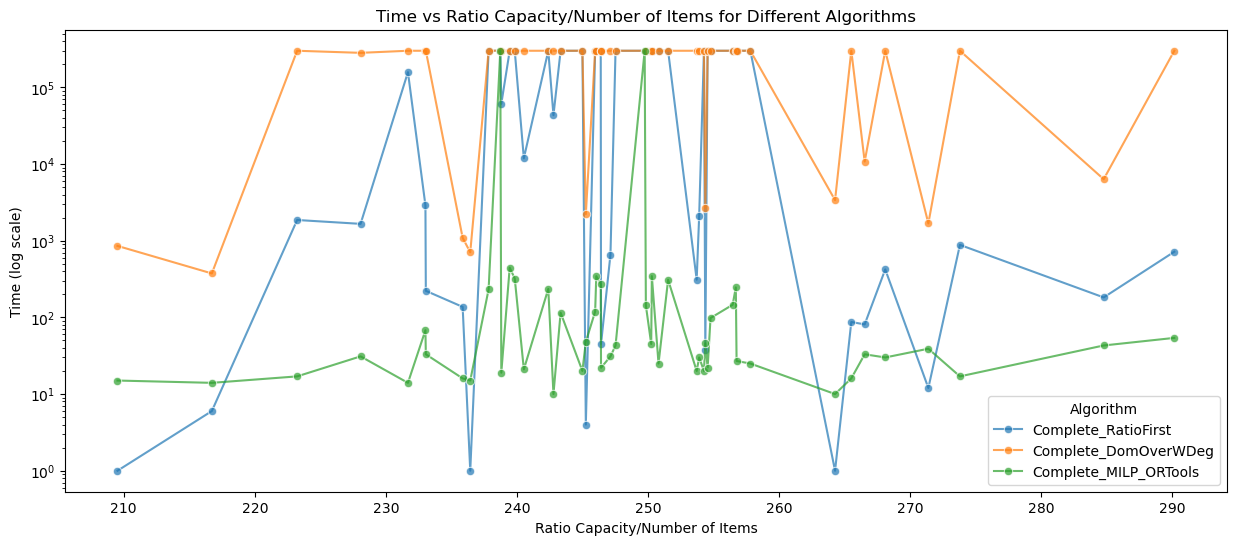

In [38]:
#### Plot time vs ratio n/capacity for different algorithms ####
complete_methods = ['Complete_RatioFirst', 'Complete_DomOverWDeg', 'Complete_MILP_ORTools']
plt.figure(figsize=(15, 6))

sns.lineplot(data=data_concat.loc[data_concat['Method'].isin(complete_methods)], x=data_concat['Capacity'] / data_concat['n'], y='Time(ms)', hue='Method', marker='o', alpha=0.7)
plt.yscale('log')
plt.xlabel('Ratio Capacity/Number of Items')
plt.ylabel('Time (log scale)')
plt.title('Time vs Ratio Capacity/Number of Items for Different Algorithms')
plt.legend(title='Algorithm')

plt.show()

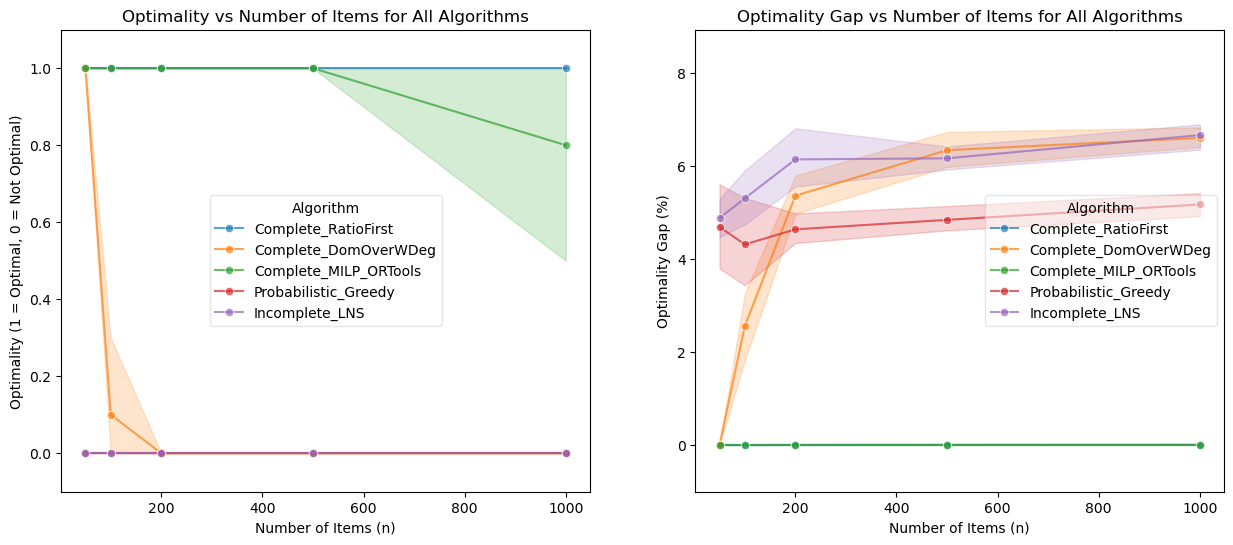

In [27]:
#### Plot optimality vs n for all algorithms ####
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
sns.lineplot(data=data_concat, x='n', y='Optimal', hue='Method', marker='o', alpha=0.7)
plt.ylim(-0.1, 1.1)
plt.xlabel('Number of Items (n)')
plt.ylabel('Optimality (1 = Optimal, 0 = Not Optimal)')
plt.title('Optimality vs Number of Items for All Algorithms')
plt.legend(title='Algorithm', fancybox=True, framealpha=0.5)

plt.subplot(1, 2, 2)
data_concat["Gap(%)"] = data_concat["Gap(%)"].astype(float)  # Convert Gap(%) to float for plotting
sns.lineplot(data=data_concat, x='n', y='Gap(%)', hue='Method', marker='o', alpha=0.7)
plt.ylim(data_concat['Gap(%)'].min() - 1, data_concat['Gap(%)'].max() + 1)
plt.xlabel('Number of Items (n)')
plt.ylabel('Optimality Gap (%)')
plt.title('Optimality Gap vs Number of Items for All Algorithms')
plt.legend(title='Algorithm', fancybox=True, framealpha=0.5)
plt.show()

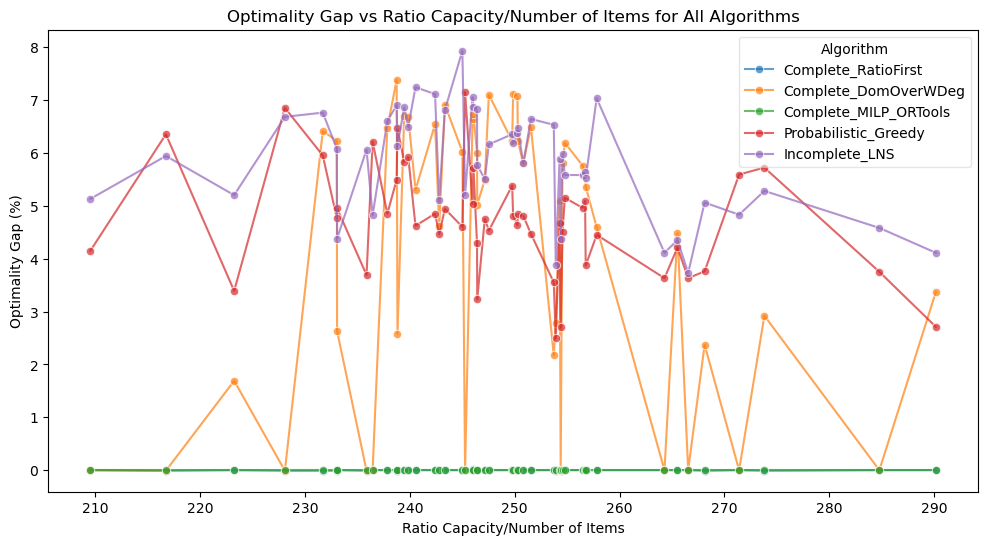

In [39]:
#### Plot optimality vs Ratio n/Capacity for all algorithms ####
plt.figure(figsize=(12, 6))

data_concat["Gap(%)"] = data_concat["Gap(%)"].astype(float)  # Convert Gap(%) to float for plotting
sns.lineplot(data=data_concat, x=data_concat['Capacity'] / data_concat['n'], y='Gap(%)', hue='Method', marker='o', alpha=0.7)
plt.xlabel('Ratio Capacity/Number of Items')
plt.ylabel('Optimality Gap (%)')
plt.title('Optimality Gap vs Ratio Capacity/Number of Items for All Algorithms')
plt.legend(title='Algorithm', fancybox=True, framealpha=0.5)
plt.show()

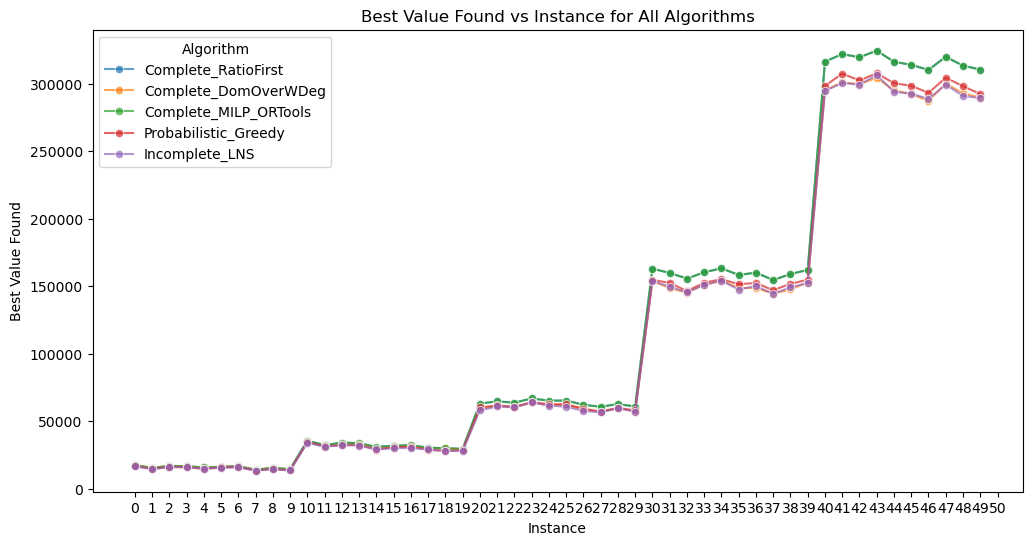

In [36]:
#### Plot best value found per instances for all algorithms ####
data_sorted = data_concat.sort_values(by=['n'])
plt.figure(figsize=(12, 6))
sns.lineplot(data=data_sorted, x='Instance', y='Value', hue='Method', marker='o', alpha=0.7)
plt.xticks(ticks=range(0, len(data_sorted['Instance'].unique())+1), labels=range(0, len(data_sorted['Instance'].unique())+1))
plt.xlabel('Instance')
plt.ylabel('Best Value Found')
plt.title('Best Value Found vs Instance for All Algorithms')
plt.legend(title='Algorithm')
plt.show()